In [1]:
import json
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Load dataset (assumed CSV format for peer reviews)
# Reading review with aspect JSONL file
data = pd.read_json(r'review_with_aspect.jsonl', lines=True)

In [2]:
from torch.optim import AdamW


In [3]:
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load JSONL data from file (one JSON object per line)
data = []

with open('review_with_aspect.jsonl', 'r') as file:  # Replace 'review_with_aspect.jsonl' with your actual file path
    for line in file:
        # Parse each line (JSON object) and append it to the data list
        data.append(json.loads(line))

# Check the first entry to ensure it loaded correctly
print(data[0])  # Example to check the first review

# Define the aspect labels (you should include all the possible aspect labels here)
aspect_labels = [
    "summary", "motivation_positive", "clarity_positive", "soundness_negative",
    "substance_negative", "meaningful_comparison_negative", "soundness_negative",
    "substance_positive", "clarity_negative", "originality_positive", "originality_negative",
    "replicability_negative", "soundness_positive", "replicability_positive",
    "motivation_negative", "clarity_positive"
]

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset for Multi-Label Classification
class ReviewDataset(Dataset):
    def __init__(self, reviews, aspect_labels, tokenizer, max_len):
        self.reviews = reviews
        self.aspect_labels = aspect_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.aspect_labels[idx]

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Convert aspect labels (True/False) to tensor for multi-label classification
        labels = torch.tensor(label, dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

# Prepare the data: create a binary vector for each aspect (1 for presence, 0 for absence)
def prepare_data(data):
    reviews = []
    aspect_vectors = []

    for entry in data:
        text = entry['text']
        labels = entry['labels']

        # Initialize aspect vector with 0 (False)
        aspect_vector = [0] * len(aspect_labels)

        # Mark aspects present in the review
        for label in labels:
            aspect_name = label[2]
            if aspect_name in aspect_labels:
                index = aspect_labels.index(aspect_name)
                aspect_vector[index] = 1  # Aspect is present

        reviews.append(text)
        aspect_vectors.append(aspect_vector)

    return reviews, aspect_vectors

# Prepare data
reviews, aspect_vectors = prepare_data(data)

{'id': 'ICLR_2020_1123', 'text': "This work studies the predictive uncertainty issue of deep learning models . In particular , this work focuses on the distributional uncertainty which is caused by distributional mismatch between training and test examples . The proposed method is developed based on the existing work called Dirichlet Prior Network ( DPN ) . It aims to address the issue of DPN that its loss function is complicated and makes the optimization difficult . Instead , this paper proposes a new loss function for DPN , which consists of the commonly used cross-entropy loss term and a regularization term . Two loss functions are respectively defined over in-domain training examples and out-of-distribution ( OOD ) training examples . The final objective function is a weighted combination of the two loss functions . Experimental study is conducted on one synthetic dataset and two image datasets ( CIFAR-10 and CIFAR-100 ) to demonstrate the properties of the proposed method and com

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
#!pip install captum

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# First Split: Split data into training (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(reviews, aspect_vectors, test_size=0.3, random_state=42)

# Second Split: Split validation set into validation (66%) and test (34%) sets (for 20% test out of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Parameters
max_len = 512
batch_size = 8

# Create DataLoader for training, validation, and testing
train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_len)
val_dataset = ReviewDataset(X_val, y_val, tokenizer, max_len)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 0.3670, Train Accuracy: 0.8276
Validation Loss: 0.2928, Validation Accuracy: 0.8687
Epoch 2/10
Train Loss: 0.2536, Train Accuracy: 0.8904
Validation Loss: 0.2511, Validation Accuracy: 0.8978
Epoch 3/10
Train Loss: 0.1972, Train Accuracy: 0.9207
Validation Loss: 0.2513, Validation Accuracy: 0.9011
Epoch 4/10
Train Loss: 0.1565, Train Accuracy: 0.9400
Validation Loss: 0.2728, Validation Accuracy: 0.8992
Early stopping triggered. Stopping training.


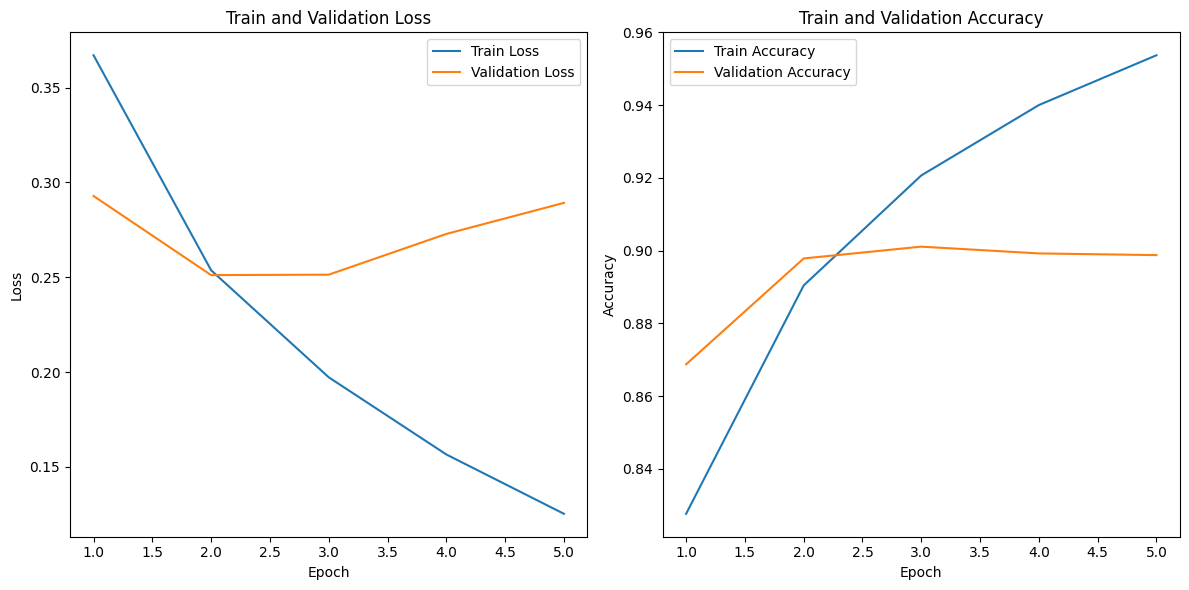

In [6]:
import torch
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Hyperparameters
epochs = 10
batch_size = 8
learning_rate = 2e-5
patience = 3  # Early stopping patience

# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aspect_labels))

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop with validation and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store the training and validation loss/accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
counter = 0

# Number of epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Calculate accuracy for training
        logits = outputs.logits
        preds = (logits > 0.5).float()  # Apply threshold
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.numel()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy for validation
            logits = outputs.logits
            preds = (logits > 0.5).float()  # Apply threshold
            correct_val_preds += (preds == labels).sum().item()
            total_val_preds += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds

    # Store values for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
torch.save(model.state_dict(), "final_model.pth")


In [10]:
import captum
# Import Captum's IntegratedGradients
from captum.attr import IntegratedGradients

# Initialize Integrated Gradients for interpretation
ig = IntegratedGradients(model)

# Sample text to interpret (you can select any sample input)
sample_text = X_train[0]

# Tokenizing the sample text
tokens = tokenizer.encode(sample_text, return_tensors='pt').to(device)

# Explain the prediction for the sample
attributions, delta = ig.attribute(tokens, target=0, return_convergence_delta=True)  # Target index can be changed

# Visualize the attributions for the tokens
tokens = tokenizer.convert_ids_to_tokens(tokens[0].cpu().numpy())
attributions = attributions[0].cpu().detach().numpy()

# Plot the token attributions
plt.figure(figsize=(10, 6))
plt.barh(tokens, attributions)
plt.xlabel('Attribution Score')
plt.title('Integrated Gradients for Token Attribution')
plt.show()


ModuleNotFoundError: No module named 'captum'

In [ ]:
"""
# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aspect_labels))

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

"""

In [8]:
# Evaluation
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = (logits > 0.5).cpu().numpy()  # Apply threshold (0.5) for multi-label classification
        predictions.extend(pred)
        true_labels.extend(labels.cpu().numpy())

# Evaluate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='micro')  # Micro F1 for multi-label classification

print(f"Test Accuracy: {accuracy}")
print(f"Test F1-Score: {f1}")

Test Accuracy: 0.21780400205233452
Test F1-Score: 0.8218623481781376
